# Unsupervised Learning

**Prerequisites**

- Pandas
- Sklearn
- Supervised Learning
- Linear Algebra

**Outcomes**

- Understand the principal component analysis algorithm for dimensionality reduction
- Understand the k-means algorithm for clustering

> Note: Parts of this notebook were inspired by sections from [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("seaborn")

color_cycle = np.array(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Overview

ML Families:

| Family | Data | examples | 
| ------ | ---- | -------- |
| Supervised | (X, y) | regression/classification |
| **Unsupervised** | (X,) | clustering/dimensionality reduction/etc | 
| Reinforcement | (s, **a**, R, s', **a'**, R'...) | games/robots/financial trading/"control" |

> Note: also semi-supervised, where some X's have a corresponding y, but not all

### Unsupervised Learning


- Today we will focus on unsupervised learning
- The overarching idea: have computer discover structure in unlabeled data
- Algorithms we will study:
    - Principal Component Analysis (PCA)
    - K-means Clustering
    - 

## Principal Component Analysis (PCA)

- PCA, at its heart, is primarily an algorithm for *dimensionality reduction*
- This means it is effective at summarizing key varaition in high dimensional data using fewer dimensions
- However, it can also be used for many tasks:
    - Feature engineering
    - Visualization
    - Noise removal/filtering
- We will focus on dimensionality reduction

### Principal Components

- The PCA algorithm represents the relationship between columns of X using the *principal components* of X
    - *Note*: principal components are sometimes called principal axes
- A principal component is a vector of the same dimensionality as $x$ (a row of $X$) that summarizes the direction of greatest variation in the data

### Graphical Example

- PCA is (perhaps) best understood visually
- We'll first show a graphical example then describe the math behind algorithm
- Consider the following dataset:

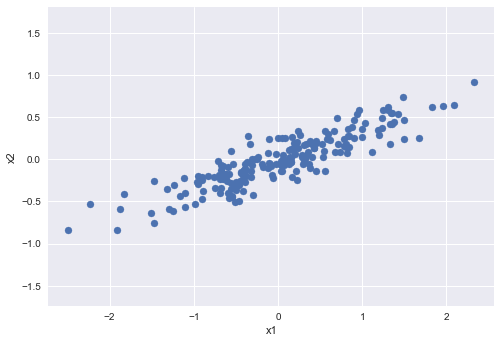

In [2]:
rng = np.random.RandomState(1)
fig, ax = plt.subplots()
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
ax.scatter(X[:, 0], X[:, 1])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.axis('equal');

- Clear linear relationship between x1 and x2
- In supervised learning...
    - we might build a model $f(x1;\theta)$ such that $x2 \approx f(x1;\theta)$
    - In words: we may try to **predict** x2 given x1
- In unsupervised learning we instead want to learn the relationship between x1 and x2

In [3]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
Xhat = pca.fit_transform(X)

- When fit is called, the PCA algorithm learns two things:
    1. `pca.components_`: matrix whose columns are principal components
    2. `pca.explained_variance_` (or `pca.explained_variance_ratio_`): variance explained by the principal components

In [4]:
print("EVR:", pca.explained_variance_ratio_)
print("PCs:\n", pca.components_)

EVR: [0.97634101 0.02365899]
PCs:
 [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


- This tells us that the direction of highest variance is -0.94 x1 and -0.32 x2
    - In other words, 3 times more variance is explained by x1 than x2
- The explained variance ratio tells us that 97% of the variance is explained by the first principal component
- Let's plot these components alongside the data

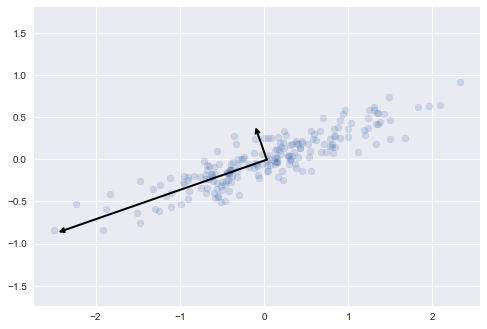

In [5]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2, color="black",
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

### Computing Principal Components

- The most intuitive algorithm for doing PCA is done iteratively
- Before iterating set $i=1$, $\tilde{X}_1 = X$, and choose the number of components K
- Then, on iteration $i$:
    1. Find a unit vector $w_i$ that maximizes the variance of a projection of $X$ onto $w_i$
        1. Mathematically can be done by choosing $w_i$ to maximize $\|\tilde{X}_i w_i\|$ (see below for $\tilde{X}_i$)
        1. Because $w_i$ must have norm 1, this is equivalent to $$w_i = \text{argmax}_w \frac{w^TX^TXw}{w^Tw}$$
    1. After choosing $w_i$, compute $\tilde{X}_{i+1}$: $$\tilde{X}_{i+1} = X - \sum_{s=1}^{i} X w_s w_s^T$$
    1. If $i< K$ continue to next iteration

Let's implement this algorithm below:

In [6]:
from scipy.optimize import minimize

def pca_iterative(X, K):
    vectors = []
    Xtilde = X
    for _ in range(K):
        xhat = Xtilde.T @ Xtilde
        def obj(w):
            return - w@xhat@w / (w@w)
        
        w = minimize(obj, 0.1*np.ones(X.shape[1])).x  # find w
        w /= np.linalg.norm(w)                        # make unit vector
        vectors.append(w)                             # store w_i
        Xtilde = Xtilde - X @ np.outer(w, w)          # update Xtilde
    
    return np.column_stack(vectors)

In [7]:
print("Iterative PCs:\n", pca_iterative(X, 2))
print("pca.components_:\n", pca.components_)

Iterative PCs:
 [[ 0.94465994 -0.32805124]
 [ 0.32805122  0.94465993]]
pca.components_:
 [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


Note: a projection on $[0.944, 0.328]$ will be the same as one on $[-0.944, -0.328]$, so these principal components are equivalent

### Comments

- The algorithm we implemented above was descriptive, but quite inefficient
- On each iteration we used a non-linear minimizer to find $w_i$
- Using some linear algebra tricks, we could have computed the principal components much more succinctly...

### PCA via eigen decomposition

- For a matrix $X$ whose columns have mean 0, the matrix $X^TX$ is the covariance matrix of $X$
- Principal components end up being eigenvectors of covariance matrix
    - Explained variance is associated eigenvalue

In [8]:
cov = X.T@X
vals, vecs = np.linalg.eig(cov)

In [9]:
print("vecs:\n", vecs)
pca.components_

vecs:
 [[ 0.94465994 -0.3280512 ]
 [ 0.3280512   0.94465994]]


array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

- Recall that eigenvalues are only unique up to a scalar multiple
- Multiplying the first column of `vecs` by `-1` gives the components from PCA

- Also, if we divide `vals` by its sum, we get the explained variance ratio:

In [10]:
print("vals / vals.sum():", vals/vals.sum())
pca.explained_variance_ratio_

vals / vals.sum(): [0.976092 0.023908]


array([0.97634101, 0.02365899])

### PCA via SVD

- By more linear algebra magic (trust us!), we can also do PCA via the singular value decomposition
- Recall that the SVD of a matrix $X$ is $$X = U \Sigma W^T,$$
    - $U$: n by n matrix whose columns are orthogonal unit vectors (left eigenvectors of $X$)
    - $\Sigma$: diagonal matrix of singular values (eigenvalues)
    - $W$: d by d matrix of orthogonal unit vectors (right eigenvectors of $X$)
- $W$ is our matrix of principal components
- The explained variance is related to the diagonal entries of $\Sigma$

In [11]:
_, _, WT = np.linalg.svd(X)

print("WT:\n", WT)
pca.components_

WT:
 [[ 0.94465994  0.3280512 ]
 [ 0.3280512  -0.94465994]]


array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

## Clustering

- Another sub-problem in unsupervised learning is clustering
- In clustering, observations are grouped together according to their similarity to other observations
- The notion of similar typically depends on the *distance* between points accoring to some *metric*

### K-means

- A common clustering algorithm is called k-means clustering
- In k-means clustering
    - $k$ centroids (vectors) are chosen such that...
    - The average distance from all points to their nearest centroid is minimized
- Each observation is assigned to a single centroid
- The set of observations assigned to the same centroid is called a cluster

### Computing k-means

- In order to apply k-means to a dataset, the following happens:
    1. A number $k$ is fixed and a metric $\rho$ is chosen
    2. $k$ random vectors are proposed as centroids
    3. Repeat the following until convergence:
        1. Assign each observation to nearest current centroid
        2. Move the centroid to the mean value of all its assigned observations
- The process terminates with $k$ vectors that satisfy:
    - All observations are closest to their assigned centroid that all other centroids
    - All centroids are at the center of their assigned set of observations

We can code up the proposed algorithm by hand...

In [12]:
from sklearn import metrics


def kmeans(k, X) -> np.ndarray:
    # to get a proposal set of centroids, randomly
    # sample from rows of X
    inds = np.random.randint(0, X.shape[0], size=k)
    centroids = X[inds, :]
    while True:
        labels = metrics.pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.max(np.abs(centroids - new_centroids)) < 1e-5:
            return centroids, labels

        centroids = new_centroids

### Example: made up data

- We will use `sklearn.datasets.make_blobs` to generate clusters of data
- We pick the number of samples, features, and clusters
- We'll also visualize the clusters below

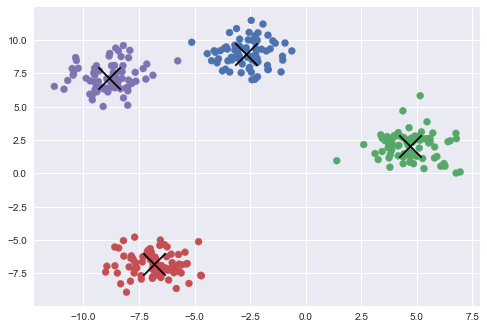

In [13]:
from sklearn import datasets

np.random.seed(42)
k_true = 4
X2, true_labels = datasets.make_blobs(n_samples=300, n_features=2, centers=k_true)
true_centers = np.array([X2[true_labels==i].mean(axis=0) for i in range(k_true)])


def plot_clusters(X, labels, centers, ax):
    ax.scatter(X2[:, 0], X2[:, 1], c=color_cycle[labels])
    ax.scatter(centers[:, 0], centers[:, 1], marker="x", c="k", s=500);
    
    
fig, ax = plt.subplots()
plot_clusters(X2, true_labels, true_centers, ax)

- Let's test our kmeans function on this dataset

In [14]:
centers, labels = kmeans(k_true, X2)

In [15]:
centers

array([[-6.83235205, -6.83045748],
       [-2.70981136,  8.97143336],
       [-8.87357218,  7.17458342],
       [ 4.7182049 ,  2.04179676]])

In [16]:
true_centers

array([[-2.66914955,  8.97847783],
       [ 4.7182049 ,  2.04179676],
       [-6.83235205, -6.83045748],
       [-8.83205052,  7.19149695]])

Notice that these centroids are not in the same order, but are approximately the same:

In [17]:
centers - true_centers[[2,0,3,1], :]

array([[ 0.        ,  0.        ],
       [-0.04066181, -0.00704447],
       [-0.04152167, -0.01691353],
       [ 0.        ,  0.        ]])

We can verify that they group the points into the same clusters:

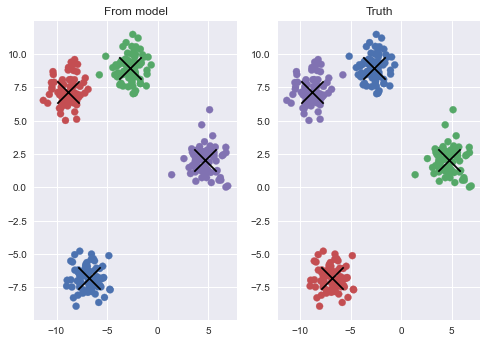

In [18]:
# plot
fig, ax = plt.subplots(1, 2)

plot_clusters(X2, labels, centers, ax[0])
plot_clusters(X2, true_labels, true_centers, ax[1])

ax[0].set_title("From model")
ax[1].set_title("Truth");

#### Notes

- The model discovered the clusters nearly perfectly (one observation was assigned to an incorrect cluster)
- We have to choose the number of clusters
    - This time we knew the "correct" answer... in practice we won't
- This dataset was simulated specifically to have clusters of points around centroids
- Kmeans can be slow for "large" data
    - Each step requires computing distance between proposed centroid and *all* observations
    - If either N or D is large, this can be costly